## Libraries

In [1735]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
from torch.utils.data import Subset, DataLoader
from torch.utils.data import Dataset

- Snakke om hvilke bibliotek vi bruker og hvorfor (pytorch)
- fordeler og ulemper med dem
- Hvilke alternativ vi hadde å velge mellom

## Loading and Normalizing the data 

In [1651]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

training_data = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_data = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


- Introdusere normalisering og hvorfor vi bruker denne normaliseringen (Burde vi endre den?) finn formellen for å komme fram til normaliseringen
- Introdusere CIFAR-10 datasettet
- Snakke om treningsdata og testdata til CIFAR-10 datasettet

## Visualisation of the data

In [1652]:
# Shape of image
img, label = training_data[0]
img.size()

torch.Size([3, 32, 32])

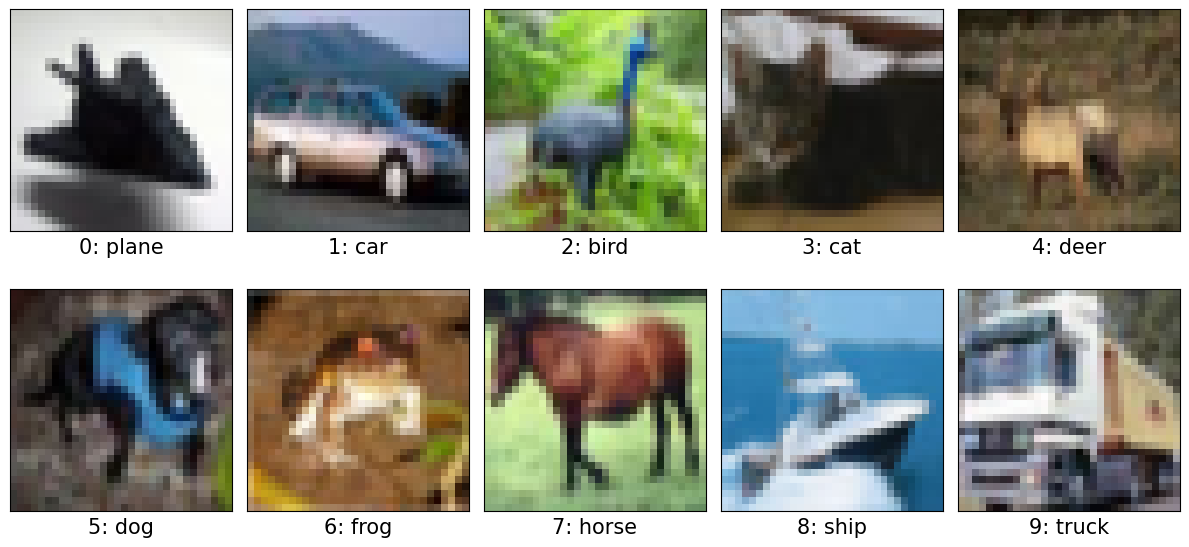

In [1653]:
# Visualize one training image per class
sample_images = [training_data.data[np.asarray(training_data.targets) == label][0] for label in range(10)]

# Create a figure with 2 rows and 5 columns
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

for i, axis in enumerate(axes.flat):
    axis.set_xlabel(f"{i}: {classes[i]}", fontsize=15)
    axis.imshow(sample_images[i])
    axis.set_xticks([])
    axis.set_yticks([])  

plt.tight_layout()
plt.show()


- Vi skal lage en binærklassifiserer for frosker
- Vet ikke helt hva vi kan snakke om her?

In [1754]:
def print_stats(dataset, class_names):
    from torch.utils.data import Subset

    label_counts = {}

    if isinstance(dataset, Subset):
        targets = dataset.dataset
        indices = dataset.indices
    else:
        targets = dataset
        indices = range(len(dataset))

    for i in indices:
        _, label = targets[i]
        if label not in label_counts:
            label_counts[label] = 0
        label_counts[label] += 1

    print(f"Total images: {len(indices)}")
    for label in sorted(label_counts):
        print(f"Label {label} ({class_names[label]}): {label_counts[label]}")


- Funksjon for å gi infromasjon om et gitt datasett
- Denne blir brukt bare for å få ett overblikk av dataen før og etter vi endrer den
- Denne kan også senere å bli gjort om til å lage grafer til dataen (men vet ikke om det er nødvendig)
- "Bør endre den"

In [1755]:
print("Traning data")
print_stats(training_data, classes)
print("\n")
print("Test data")
print_stats(test_data, classes)

Traning data
Total images: 50000
Label 0 (plane): 5000
Label 1 (car): 5000
Label 2 (bird): 5000
Label 3 (cat): 5000
Label 4 (deer): 5000
Label 5 (dog): 5000
Label 6 (frog): 5000
Label 7 (horse): 5000
Label 8 (ship): 5000
Label 9 (truck): 5000


Test data
Total images: 10000
Label 0 (plane): 1000
Label 1 (car): 1000
Label 2 (bird): 1000
Label 3 (cat): 1000
Label 4 (deer): 1000
Label 5 (dog): 1000
Label 6 (frog): 1000
Label 7 (horse): 1000
Label 8 (ship): 1000
Label 9 (truck): 1000


- Dette blir nok snakket om når vi presenterer dataen
- Men det er sikkert noe å snakke om her 

## Building the Traningdataset

In [1656]:
class FrogBinaryDataset(Dataset):
    def __init__(self, subset):
        self.subset = subset 

    def __getitem__(self, idx):
        data, label = self.subset[idx]
        # Convert to binary: 1 if frog (label 6), else 0
        if label == 6:
            binary_label = 1
        else:
            binary_label = 0
        return data, binary_label

    def __len__(self):
        return len(self.subset)

- Dette er en klasse som tar inn ett data sett og gjør "labels" om til binære verdier
- Det er sikkert en bedre måte å gjøre dette på (jeg fant det i dokumentasjon), men det funker :)
- Forklare hvorfor vi gjør dette og hva fordelen med å gjøre dette er

In [1745]:
print("Traning data")
print_stats(training_data, classes)

Traning data
Total images: 50000
Label 0 (plane): 5000
Label 1 (car): 5000
Label 2 (bird): 5000
Label 3 (cat): 5000
Label 4 (deer): 5000
Label 5 (dog): 5000
Label 6 (frog): 5000
Label 7 (horse): 5000
Label 8 (ship): 5000
Label 9 (truck): 5000


- Tidligere hadde jeg splittet dataen sånn at det var 50% frosker og 50% en lik fordeling av alle andre klassene, men det gjorde at jeg fikk veldig dårlige resultater under validering så jeg endret det tilbake til dette. Men vi må spørre om det er en annen måte vi kan splitte denne treningsdataen.
- Kan vi endre på forskebildene slik at vi får flere froskebilder å trene på, evt hvordan?

In [1658]:
# Convert to binary values 1 for frogs and o for other classes
binary_trainset = FrogBinaryDataset(training_data)

# Put into dataloader
trainloader = DataLoader(binary_trainset, batch_size=64, shuffle=True)

- Gjør om til binære verdier
- Putter det i en DataLoader for lettere bruk

## Building the Test and Validationdataset

In [1757]:
# Calculate lengths for the split
total_size = len(test_data)
split_size = int(total_size // 2)

test_subset = Subset(test_data, range(split_size))
val_subset = Subset(test_data, range(split_size, total_size))


- Her også hadde jeg tidligere en annen fordeling på dataen, men nå har jeg bare delt testdataen 50/50
- Spør smeinar leder om hvordan vi bør splitte dataen

In [1758]:
# Wrap in DataLoaders
testloader = DataLoader(test_subset, batch_size=64, shuffle=True)
valloader = DataLoader(val_subset, batch_size=64, shuffle=True)

In [1759]:
print("Testdata")
print_stats(test_subset, classes)
print("\n")
print("Validationdata")
print_stats(val_subset, classes)

Testdata
Total images: 5000
Label 0 (plane): 488
Label 1 (car): 505
Label 2 (bird): 512
Label 3 (cat): 497
Label 4 (deer): 507
Label 5 (dog): 488
Label 6 (frog): 491
Label 7 (horse): 495
Label 8 (ship): 504
Label 9 (truck): 513


Validationdata
Total images: 5000
Label 0 (plane): 512
Label 1 (car): 495
Label 2 (bird): 488
Label 3 (cat): 503
Label 4 (deer): 493
Label 5 (dog): 512
Label 6 (frog): 509
Label 7 (horse): 505
Label 8 (ship): 496
Label 9 (truck): 487


In [ ]:
# Convert to binary values 1 for frogs and 0 for other classes
binary_testset = FrogBinaryDataset(test_data)

## Convolutional Neural Network

In [1662]:
class FrogClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        # Convolutional layers
        self.conv_layer1 = nn.Conv2d(3, 12, kernel_size=5)

        self.bn1 = nn.BatchNorm2d(12)
        
        self.pool = nn.MaxPool2d(2, 2)                      
        
        self.conv_layer2 = nn.Conv2d(12, 24, kernel_size=5) 
        self.bn2 = nn.BatchNorm2d(24)
        
        # Fully connected layers
        self.fully_connected1 = nn.Linear(24 * 5 * 5, 120)
        self.bn3 = nn.BatchNorm1d(120)
        self.dropout1_fc = nn.Dropout(p=0.2)
        
        self.fully_connected2 = nn.Linear(120, 84)
        self.bn4 = nn.BatchNorm1d(84)
        self.dropout2_fc = nn.Dropout(p=0.2)  
        
        self.fully_connected3 = nn.Linear(84, 2)

    def forward(self, data):
        data = self.pool(F.relu(self.bn1(self.conv_layer1(data))))
        data = self.pool(F.relu(self.bn2(self.conv_layer2(data))))
        
        data = torch.flatten(data, 1)
        
        data = F.relu(self.bn3(self.fully_connected1(data)))
        data = self.dropout1_fc(data)
        
        data = F.relu(self.bn4(self.fully_connected2(data)))
        data = self.dropout2_fc(data)
        
        data = self.fully_connected3(data)
        
        return data


- Her er det veldig mye å snakke om
- Hvorfor vi har brukt batch normalisering
- Hvorfor vi valgte denne arkitekturen
- Hvorfor vi brukte relu som activation function osv 

In [ ]:
# defining an optimizer and lossfucntion
neural_network = FrogClassifier()
loss_function = nn.CrossEntropyLoss()
optimizer = SGD(neural_network.parameters(), lr=0.001, momentum=0.9)


- Hvorfor vi bruker CrossEntropy og SGD
- Fordeler med det

## Traning The Model

In [1664]:
list_of_train_loss = []
list_of_val_loss = []
epochs = range(20)

for epoch in epochs:
    print(f"\nEpoch {epoch} / {max(epochs)}")
    
    # Traning 
    neural_network.train()
    running_loss = 0.0
    
    for inputs, labels in trainloader:
        optimizer.zero_grad()
        outputs = neural_network(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    avg_train_loss = running_loss / len(trainloader)
    list_of_train_loss.append(avg_train_loss)
    print(f"Train Loss: {avg_train_loss:.4f}")

    neural_network.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    # Validation
    with torch.no_grad():
        for val_inputs, val_labels in valloader:
            outputs = neural_network(val_inputs)
            loss = loss_function(outputs, val_labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total += val_labels.size(0)
            correct += (predicted == val_labels).sum().item()
    
    avg_val_loss = val_loss / len(valloader)
    print(f"Validation Loss: {avg_val_loss:.4f}")
    list_of_val_loss.append(avg_val_loss)




Epoch 0 / 19
Train Loss: 0.2440
Validation Loss: 0.1839

Epoch 1 / 19
Train Loss: 0.1790
Validation Loss: 0.1673

Epoch 2 / 19
Train Loss: 0.1627
Validation Loss: 0.1750

Epoch 3 / 19
Train Loss: 0.1530
Validation Loss: 0.1432

Epoch 4 / 19
Train Loss: 0.1452
Validation Loss: 0.1579

Epoch 5 / 19
Train Loss: 0.1383
Validation Loss: 0.1887

Epoch 6 / 19
Train Loss: 0.1322
Validation Loss: 0.1527

Epoch 7 / 19
Train Loss: 0.1266
Validation Loss: 0.1357

Epoch 8 / 19
Train Loss: 0.1185
Validation Loss: 0.1791

Epoch 9 / 19
Train Loss: 0.1161
Validation Loss: 0.1428

Epoch 10 / 19
Train Loss: 0.1106
Validation Loss: 0.1320

Epoch 11 / 19
Train Loss: 0.1053
Validation Loss: 0.1445

Epoch 12 / 19
Train Loss: 0.1023
Validation Loss: 0.1353

Epoch 13 / 19
Train Loss: 0.0958
Validation Loss: 0.1320

Epoch 14 / 19
Train Loss: 0.0938
Validation Loss: 0.1548

Epoch 15 / 19
Train Loss: 0.0908
Validation Loss: 0.1505

Epoch 16 / 19
Train Loss: 0.0849
Validation Loss: 0.1277

Epoch 17 / 19
Train Los

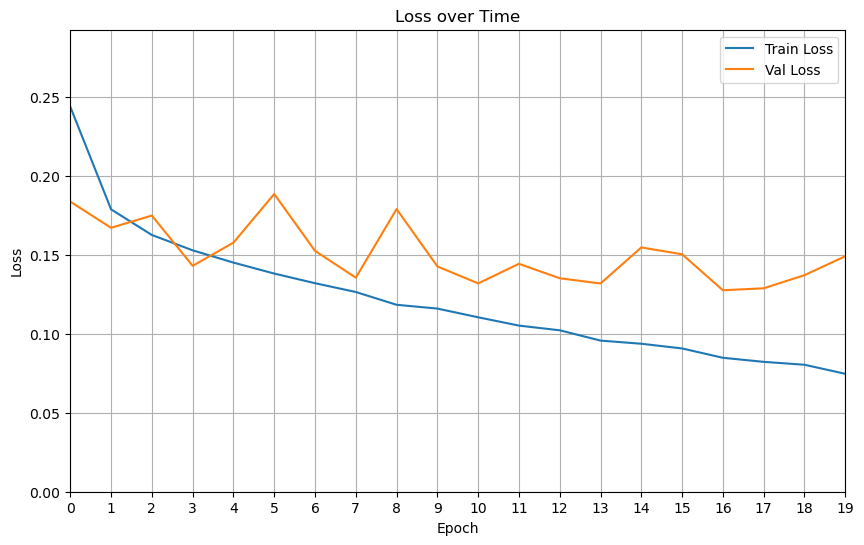

In [1665]:
# Plotting
fig, graph = plt.subplots(figsize=(10, 6))

# Plot average losses per epoch
graph.plot(list(epochs), list_of_train_loss, label='Train Loss', color='tab:blue')
graph.plot(list(epochs), list_of_val_loss, label='Val Loss', color='tab:orange')

# Axis limits and labels
graph.set_ylim(0, max(list_of_val_loss + list_of_train_loss) * 1.2)
graph.set_xlim(min(epochs), max(epochs))
graph.set_xticks(epochs) 
graph.legend()
plt.title("Loss over Time")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [1666]:
# Save the model
PATH = './cifar_net.pth'
torch.save(neural_network.state_dict(), PATH)

## Evaluation

In [1667]:
network = neural_network
network.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

In [1668]:
# set model to eval mode
neural_network.eval()

FrogClassifier(
  (conv_layer1): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_layer2): Conv2d(12, 24, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fully_connected1): Linear(in_features=600, out_features=120, bias=True)
  (bn3): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1_fc): Dropout(p=0.2, inplace=False)
  (fully_connected2): Linear(in_features=120, out_features=84, bias=True)
  (bn4): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2_fc): Dropout(p=0.2, inplace=False)
  (fully_connected3): Linear(in_features=84, out_features=2, bias=True)
)

In [1669]:
correct = 0
recall = 0
total = 0

true_positive = 0
false_negative = 0

with torch.no_grad():
    for val_inputs, val_labels in valloader:
        outputs = neural_network(val_inputs)
        loss = loss_function(outputs, val_labels)
        val_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += val_labels.size(0)
        correct += (predicted == val_labels).sum().item()

        # For recall calculation (frog = 1)
        true_positive += ((predicted == 1) & (val_labels == 1)).sum().item()
        false_negative += ((predicted == 0) & (val_labels == 1)).sum().item()

val_accuracy = 100 * correct / total
recall = true_positive / (true_positive + false_negative + 1e-8)  

print(f"Accuracy: {val_accuracy:.2f}% | Recall (frog): {recall:.4f}")


Accuracy: 93.97% | Recall (frog): 0.8023


## Prdiction on New image

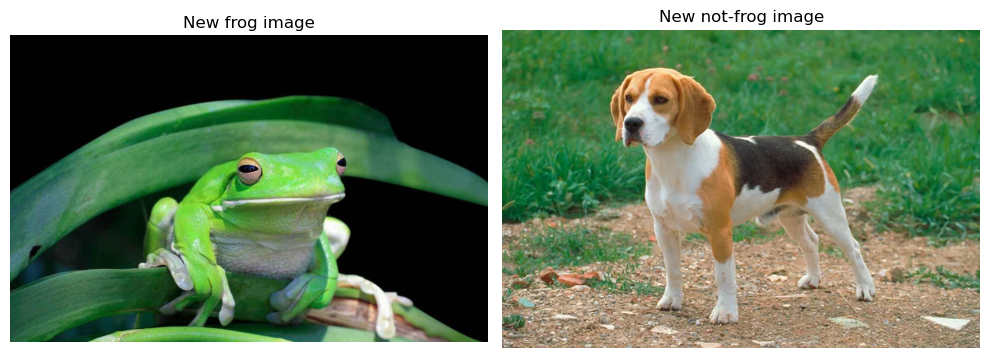

In [1728]:
# Present new image
frog_image = Image.open("/Users/stefannaess/Documents/GitHub/INFO284_SemesterOppgave_2025V/Oppgave2/new_frog_picture.jpg")
not_frog_image = Image.open("/Users/stefannaess/Documents/GitHub/INFO284_SemesterOppgave_2025V/Oppgave2/new_dog_picture.jpg")

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(frog_image)
axes[0].set_title("New frog image")
axes[0].axis("off")


axes[1].imshow(not_frog_image)
axes[1].set_title("New not-frog image")
axes[1].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# Transforms

# Transform for changing the image into a 32x32 and normalizing
new_transform = transforms.Compose([
    transforms.Resize((32, 32)),            
    transforms.ToTensor(),                 
    transforms.Normalize((0.5, 0.5, 0.5),     
                         (0.5, 0.5, 0.5))
])

# Unnormalize for display
unnormalize = transforms.Normalize(
    mean=[-1.0, -1.0, -1.0],
    std=[2.0, 2.0, 2.0]
)

In [ ]:
# Present image to be processed

# Apply transform
transformed_frog_image = new_transform(frog_image)
transformed_not_frog_image = new_transform(not_frog_image)


transformed_frog_image = unnormalize(transformed_frog_image)
transformed_not_frog_image = unnormalize(transformed_not_frog_image)

# Convert to (H, W, C) and clip for valid pixel range
display_image_forg = transformed_frog_image.permute(1, 2, 0).numpy()
display_image_not_forg = transformed_not_frog_image.permute(1, 2, 0).numpy()

# Clip intervals outside of normalisation range
display_image_forg = np.clip(display_image_forg, 0, 1)
display_image_not_forg = np.clip(display_image_not_forg, 0, 1)

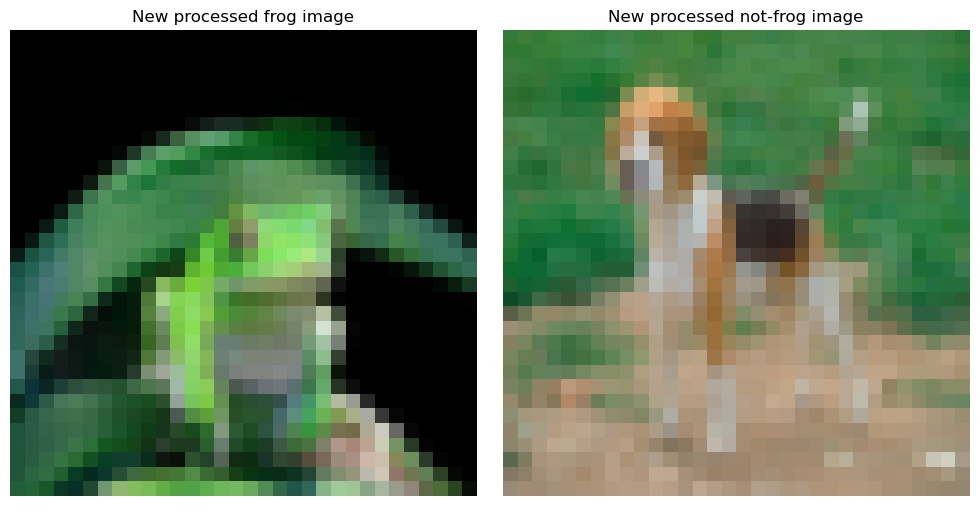

In [1731]:
# Display preprocessed images

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(display_image_forg)
axes[0].set_title("New processed frog image")
axes[0].axis("off")


axes[1].imshow(display_image_not_forg)
axes[1].set_title("New processed not-frog image")
axes[1].axis("off")

plt.tight_layout()
plt.show()

In [1725]:
# Load in model
model = FrogClassifier()
model.load_state_dict(torch.load("./cifar_net.pth"))
model.eval()

FrogClassifier(
  (conv_layer1): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_layer2): Conv2d(12, 24, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fully_connected1): Linear(in_features=600, out_features=120, bias=True)
  (bn3): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1_fc): Dropout(p=0.2, inplace=False)
  (fully_connected2): Linear(in_features=120, out_features=84, bias=True)
  (bn4): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2_fc): Dropout(p=0.2, inplace=False)
  (fully_connected3): Linear(in_features=84, out_features=2, bias=True)
)

In [1726]:
images = [frog_image, not_frog_image]
# Predicted labels
labels = []

# Make prediction
for img in images:
    # Preprocess image
    processed_img = new_transform(img).unsqueeze(0)
    
    with torch.no_grad():
        
        output = model(processed_img)

        # Prediction
        prediction = torch.argmax(output, dim=1).item()

        # Confidence
        probability = torch.softmax(output, dim=1)
        confidence = probability[0][prediction].item()

        label = f"{'Frog' if prediction == 1 else 'Not Frog'} ({confidence:.2%})"
        labels.append(label)


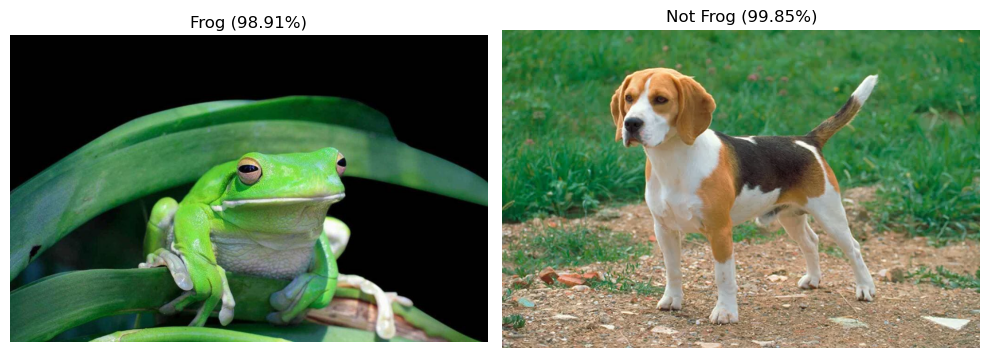

In [1727]:
# Create plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display images
for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.set_title(labels[i], fontsize=12)
    ax.axis("off")

plt.tight_layout()
plt.show()